# In this notebook we will tackle PCA analysis through the GPA kaggle competition

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
sys.path.append("../..")
import utilities_plot as up
import utilities

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


In [43]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)
train.head()

(76518, 38)


,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


# Missing values

In [44]:
train.isna().any()

id                                                False
Marital status                                    False
Application mode                                  False
Application order                                 False
Course                                            False
Daytime/evening attendance                        False
Previous qualification                            False
Previous qualification (grade)                    False
Nacionality                                       False
Mother's qualification                            False
Father's qualification                            False
Mother's occupation                               False
Father's occupation                               False
Admission grade                                   False
Displaced                                         False
Educational special needs                         False
Debtor                                            False
Tuition fees up to date                         

In [45]:
test.isna().any()

id                                                False
Marital status                                    False
Application mode                                  False
Application order                                 False
Course                                            False
Daytime/evening attendance                        False
Previous qualification                            False
Previous qualification (grade)                    False
Nacionality                                       False
Mother's qualification                            False
Father's qualification                            False
Mother's occupation                               False
Father's occupation                               False
Admission grade                                   False
Displaced                                         False
Educational special needs                         False
Debtor                                            False
Tuition fees up to date                         

In [46]:
label_target = {'Graduate':0, 'Dropout': 1, 'Enrolled':2}

train_transfo = train.copy()
test_transfo = test.copy()

train_transfo["Target"] = train_transfo["Target"].apply(lambda x: label_target[x])

# Reduce dimension : PCA

https://datascientest.com/acp

In our case, we have 38 features in this competition so we will focus on reducing it thanks to the PCA method : 

### 1. Perform the initial PCA  
- After standardizing the data and calculating the covariance matrix (or a correlation matrix if the data are standardized), we extract the associated eigenvalues and eigenvectors.
- The eigenvalues represent the amount of variance explained by each component.

In [47]:
norm = StandardScaler()

train_norm = norm.fit_transform(train_transfo)

# check
print(np.mean(train_norm), np.std(train_norm))

train_norm_df = pd.DataFrame(train_norm, columns = train.columns)
train_norm_df.head()

7.60715241553481e-17 0.9999999999999997


,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,-1.732028,-0.253437,-0.902423,-0.524066,0.131258,0.304173,-0.308308,-0.580138,-0.066801,-1.223274,...,-0.146765,0.040921,-0.066933,0.718660,0.505317,-0.135127,-0.158418,-0.449110,0.933176,-0.937489
1,-1.731983,-0.253437,0.056682,-0.524066,0.131258,0.304173,-0.308308,-0.671086,-0.066801,-0.054394,...,-0.146765,0.040921,0.504003,-1.445110,-1.735681,-0.135127,-0.158418,-0.449110,0.933176,0.362619
2,-1.731938,-0.253437,0.056682,0.289183,0.140130,0.304173,-0.308308,0.420293,-0.066801,-1.093399,...,-0.146765,0.040921,-2.065210,-1.445110,-1.735681,-0.135127,1.763675,-0.663578,-0.372698,0.362619
3,-1.731892,-0.253437,-0.902423,1.102431,0.276537,0.304173,-0.308308,-0.125396,-0.066801,-0.054394,...,-0.146765,1.270048,1.074940,1.079288,0.575895,-0.135127,-0.158418,-0.449110,0.933176,1.662727
4,-1.731847,-0.253437,-0.902423,0.289183,0.276537,0.304173,-0.308308,-0.034448,-0.066801,-0.054394,...,-0.146765,0.655484,1.360408,0.718660,0.596330,-0.135127,-1.477502,0.980680,0.178079,-0.937489


### 2. Calculate the variance explained by each component
- The variance explained by a principal component is obtained by dividing its eigenvalue by the sum of all its eigenvalues.
- This gives the percentage of variance explained by each component individually.

### 3. Calculating cumulative explained variance
- The cumulative explained variance is calculated by progressively adding up the explained variances.
- For example, if the first three components explain 90% of the cumulative variance, this indicates that the dimensional space could be reduced to three components, retaining 90% of the information.


In [48]:
pca_data = PCA()
principalComponents_data = pca_data.fit_transform(train_norm)

var_cumulate = np.cumsum(pca_data.explained_variance_ratio_)

print("Explained var for each components :", pca_data.explained_variance_)
print("Explained var cumulated :", var_cumulate)

Explained var for each components : [6.26141645 3.6774091  2.08125675 1.93749773 1.85573313 1.7622184
 1.58776907 1.4908315  1.39604611 1.26420091 1.22009456 1.14742753
 1.00169816 1.00158267 0.99374736 0.9492542  0.88355569 0.80692818
 0.70189335 0.66991043 0.62315879 0.57497296 0.51421956 0.5038966
 0.47224243 0.42465386 0.42322993 0.39556127 0.28648013 0.24869689
 0.20108283 0.18266357 0.13214953 0.10315171 0.08223363 0.07244197
 0.04361873 0.02557096]
Explained var cumulated : [0.16477196 0.26154462 0.31631382 0.36729994 0.41613438 0.46250794
 0.50429079 0.54352269 0.58026026 0.61352828 0.64563561 0.67583067
 0.70219081 0.7285479  0.75469881 0.77967885 0.80293001 0.82416469
 0.84263533 0.86026432 0.87666302 0.89179369 0.9053256  0.91858587
 0.93101314 0.94218809 0.95332558 0.96373495 0.9712738  0.97781837
 0.98310996 0.98791683 0.9913944  0.99410889 0.9962729  0.99817924
 0.99932709 1.        ]


### 4. Plot the Scree Plot
- A Scree Plot is a graph representing the eigenvalues or variance explained by each component as a function of their rank.
- In this plot, we look for the inflection point where the curve begins to flatten, forming a “bend”. This point generally marks the optimum number of components to retain.

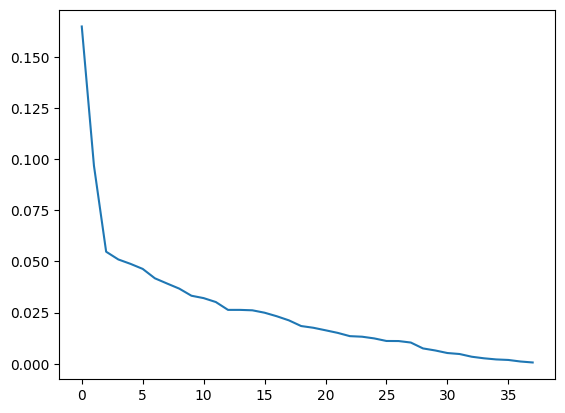

In [49]:
plt.plot(pca_data.explained_variance_ratio_)

### 5. Determining an explained variance threshold (e.g. 90-95%)
- A common method is to define a cumulative explained variance threshold, often around 90% or 95%.

In [50]:
tresh = 0.90
n_composantes_90 = np.argmax(var_cumulate >= tresh) + 1
print(f"number of components for 90 % of the explained var : {n_composantes_90}")

number of components for 90 % of the explained var : 23


### 6. Kaiser's Rule criterion (optional)
- Kaiser's Rule proposes to retain only those principal components with eigenvalues greater than 1 (in the case of a correlation matrix).
- This rule is based on the fact that components with eigenvalues below 1 explain less variance than a single standardized variable, and are therefore often considered uninformative.

In [51]:
print("Explained var for each components :", pca_data.explained_variance_)
print("Kaiser's Rule :", len([i for i in pca_data.explained_variance_ if i>1]), "components over 1")

Explained var for each components : [6.26141645 3.6774091  2.08125675 1.93749773 1.85573313 1.7622184
 1.58776907 1.4908315  1.39604611 1.26420091 1.22009456 1.14742753
 1.00169816 1.00158267 0.99374736 0.9492542  0.88355569 0.80692818
 0.70189335 0.66991043 0.62315879 0.57497296 0.51421956 0.5038966
 0.47224243 0.42465386 0.42322993 0.39556127 0.28648013 0.24869689
 0.20108283 0.18266357 0.13214953 0.10315171 0.08223363 0.07244197
 0.04361873 0.02557096]
Kaiser's Rule : 14 components over 1


### Correlation circle

In [52]:
pca_data = PCA(n_components= 2)
principalComponents_data = pca_data.fit_transform(train_norm)

[1, 2, 4, 5, 14, 17, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32]


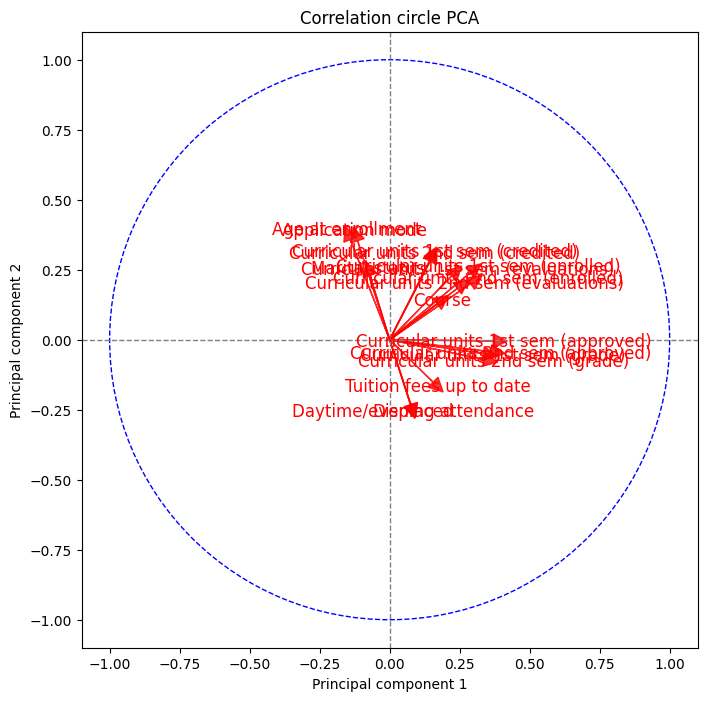

In [53]:
components = pca_data.components_.T  

fig, ax = plt.subplots(figsize=(8, 8))

# Circle
cercle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=1)
ax.add_patch(cercle)

# norm eigen vectors
contributions = np.linalg.norm(components, axis=1)

# Kaiser's Rule relevant features because too many to display in the circle
filtered_indices = list(np.where(contributions>= 0.2)[0])
print(list(filtered_indices))


# add arrow
n_features = train_norm.shape[1]
for i in filtered_indices:
    plt.arrow(0, 0, components[i, 0], components[i, 1], color='r', alpha=0.8, 
              head_width=0.05, head_length=0.05)
    plt.text(components[i, 0] * 1.1, components[i, 1] * 1.1, train.columns[i], 
             color='r', ha='center', va='center', fontsize=12)


ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)

plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("Correlation circle PCA")
ax.set_aspect('equal', 'box')

plt.show()

In [54]:
def display_eigen_arrow(component_x, component_y, pca_data, principalComponents_data):
    # Récupérer les vecteurs propres (composantes principales)
    components = pca_data.components_.T  
    n_features = principalComponents_data.shape[1]
    
    cercle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=1.5)
    
    # Créer la figure et les axes
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.add_patch(cercle)  # Ajouter le cercle aux axes
    
    # Tracer les flèches pour les deux composantes sélectionnées
    plt.arrow(0, 0, components[component_x, 0], components[component_x, 1], 
              color='r', alpha=0.5, head_width=0.05, head_length=0.1)
    plt.text(components[component_x, 0] * 1.15, components[component_x, 1] * 1.15, f"Var{component_x+1}", 
             color='r', ha='center', va='center', fontsize=12)
    
    plt.arrow(0, 0, components[component_y, 0], components[component_y, 1], 
              color='r', alpha=0.5, head_width=0.05, head_length=0.1)
    plt.text(components[component_y, 0] * 1.15, components[component_y, 1] * 1.15, f"Var{component_y+1}", 
             color='r', ha='center', va='center', fontsize=12)

    # Configurer les limites des axes
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    
    # Égaliser l'échelle et ajouter des labels
    ax.set_aspect('equal', 'box')
    plt.xlabel(f'Component {component_x}')
    plt.ylabel(f'Component {component_y}')
    plt.grid(True)
    
    plt.show()

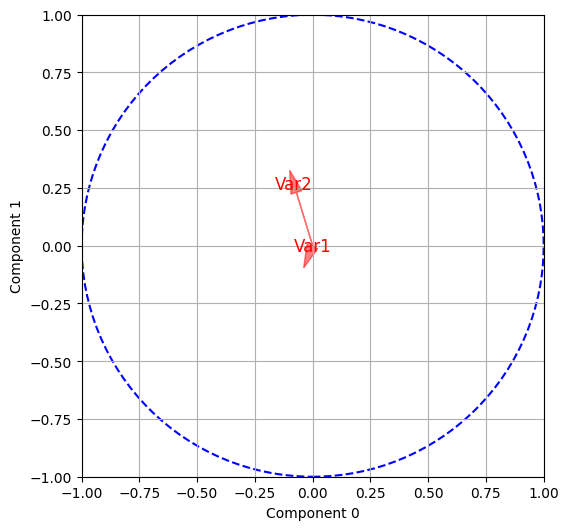

In [55]:
display_eigen_arrow(0, 1, pca_data, principalComponents_data)

Text(0, 0.5, 'Component 2')

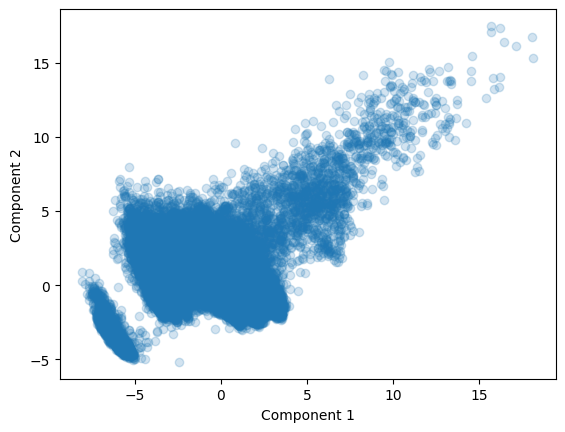

In [56]:
components = pca_data.components_.T  
n_features = principalComponents_data.shape[1]

plt.scatter(principalComponents_data[:, 0], principalComponents_data[:, 1], alpha=0.2)

plt.xlabel('Component 1')
plt.ylabel('Component 2')


# Take a look at the correlation matrix

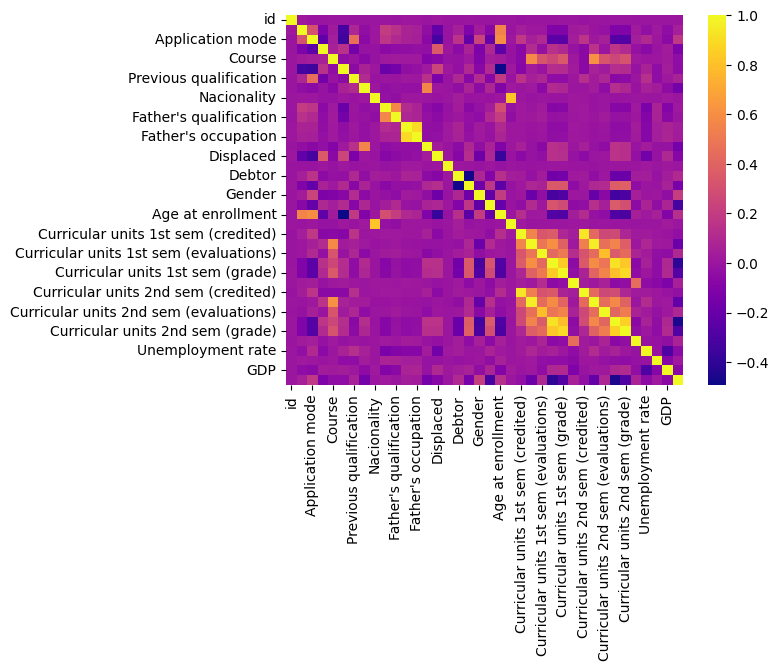

In [57]:
correlation = train_transfo.corr()
sb.heatmap(correlation, cmap = 'plasma')
plt.show()

# Classes repartition

In [58]:
train["Target"].value_counts().index

Index(['Graduate', 'Dropout', 'Enrolled'], dtype='object', name='Target')

/Users/avicenne/Documents/python/kaggle-projects/classification-projects/GPA/../../utilities_plot.py:415: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [values[i] for i in sorted_indices]
/Users/avicenne/Documents/python/kaggle-projects/classification-projects/GPA/../../utilities_plot.py:425: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='labels', y='values', data=data, palette=colors, ax=ax, edgecolor='black', linewidth=1.5)


Text(0.5, 1.0, 'distribution of target label')

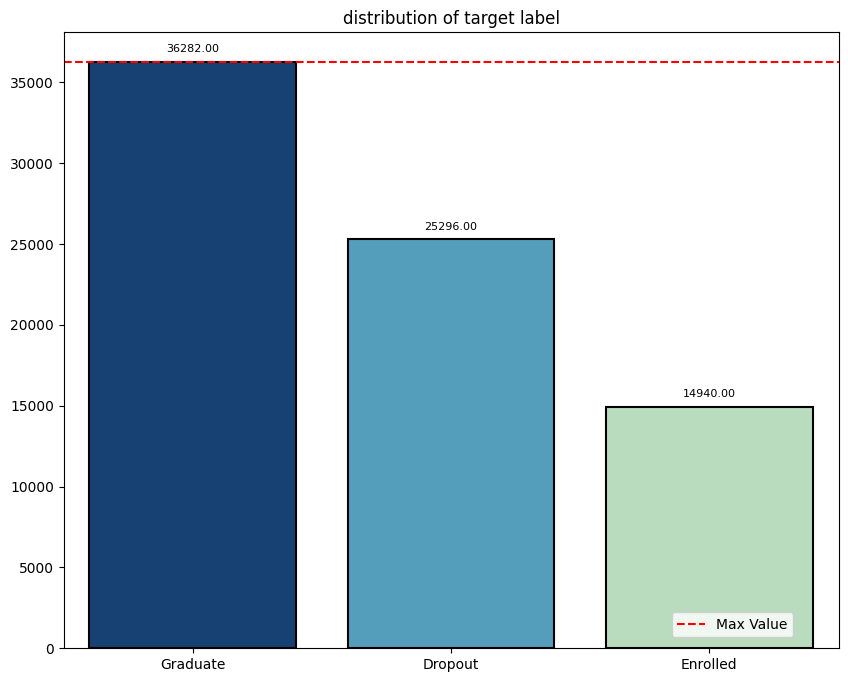

In [59]:
ax = up.plot_bar_graph(train["Target"].value_counts(), train["Target"].value_counts().index, color="GnBu_r")
ax.set_title("distribution of target label")


<Axes: xlabel='Unemployment rate', ylabel='Density'>

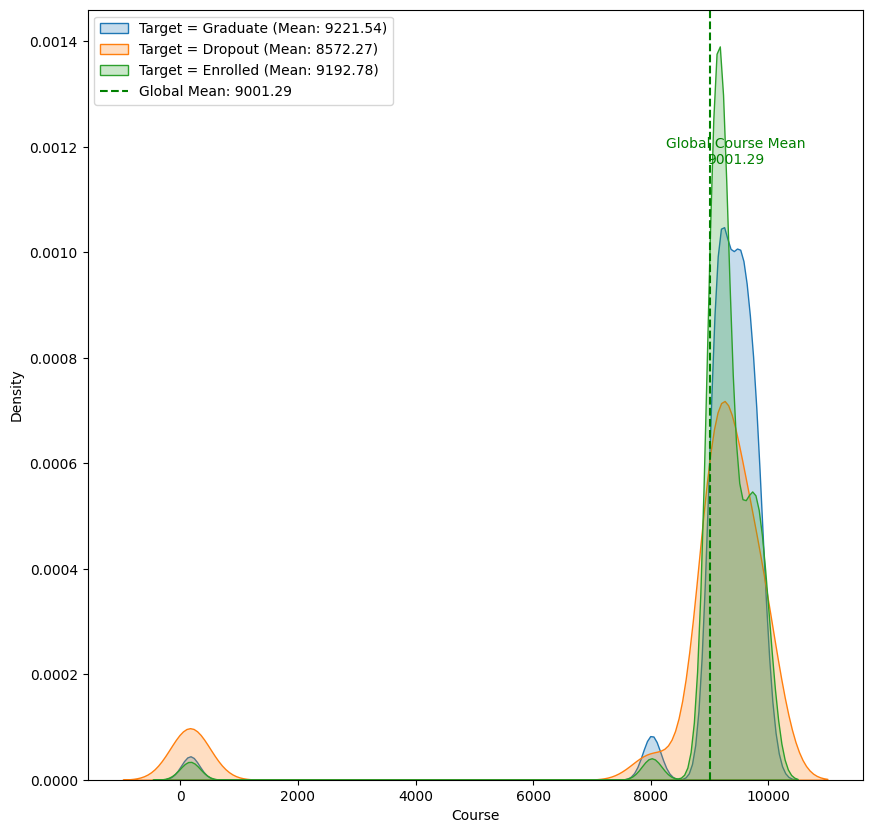

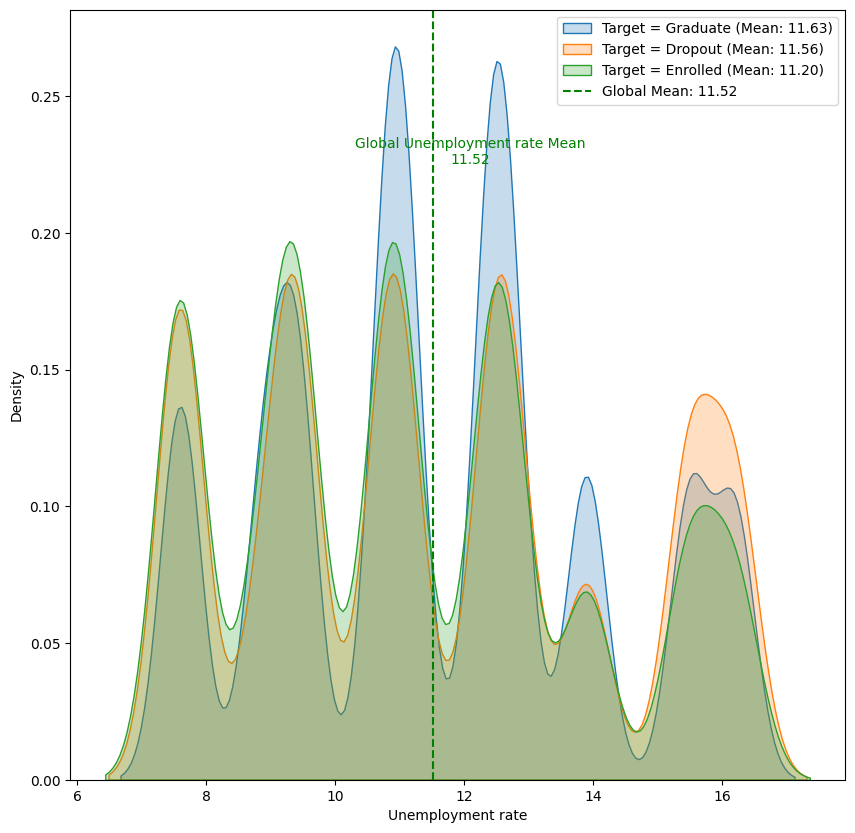

In [60]:
up.density_on_target(train, "Target", "Course")
up.density_on_target(train, "Target", "Unemployment rate")

array([<Axes: title={'center': 'Target = Graduate\nMean: 0.24'}, xlabel='Curricular units 1st sem (credited)', ylabel='Density'>,
       <Axes: title={'center': 'Target = Dropout\nMean: 0.14'}, xlabel='Curricular units 1st sem (credited)'>,
       <Axes: title={'center': 'Target = Enrolled\nMean: 0.15'}, xlabel='Curricular units 1st sem (credited)'>],
      dtype=object)

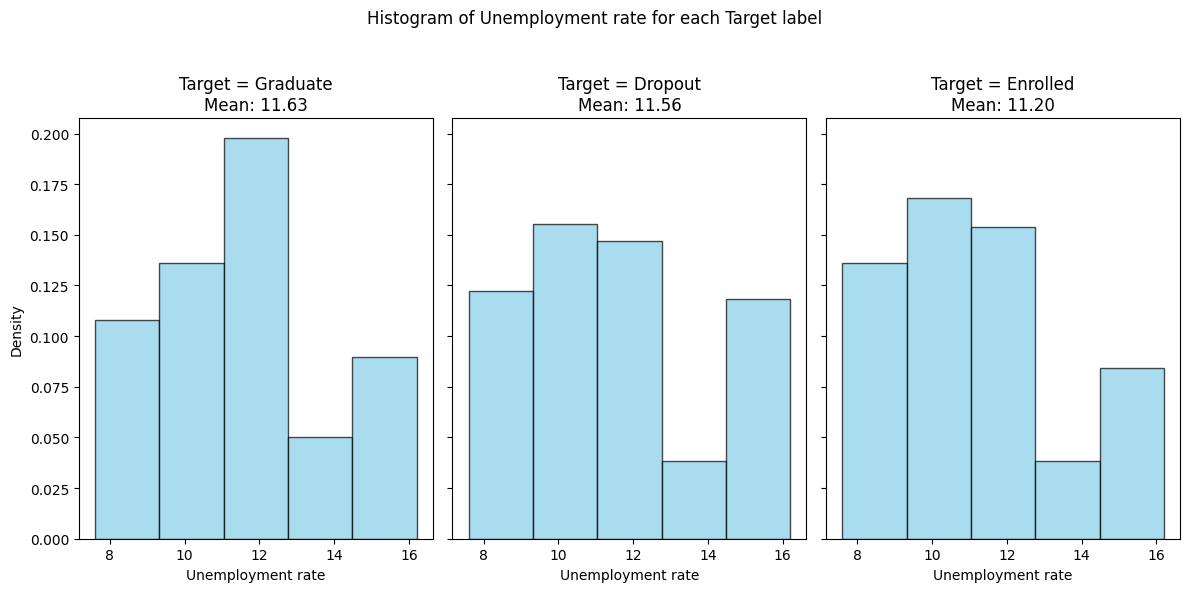

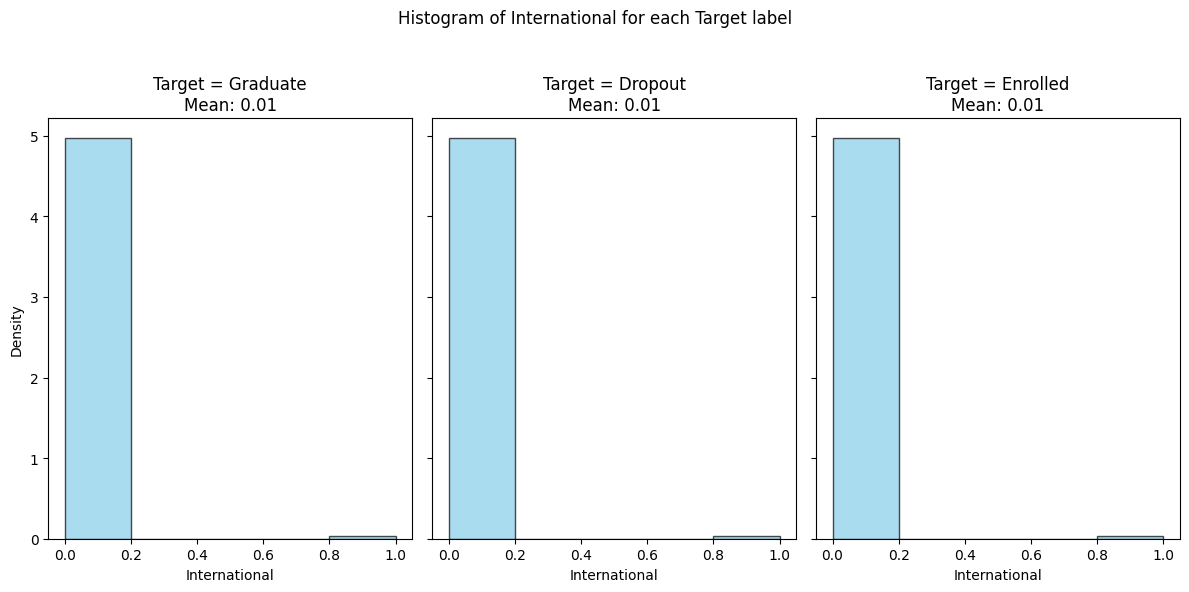

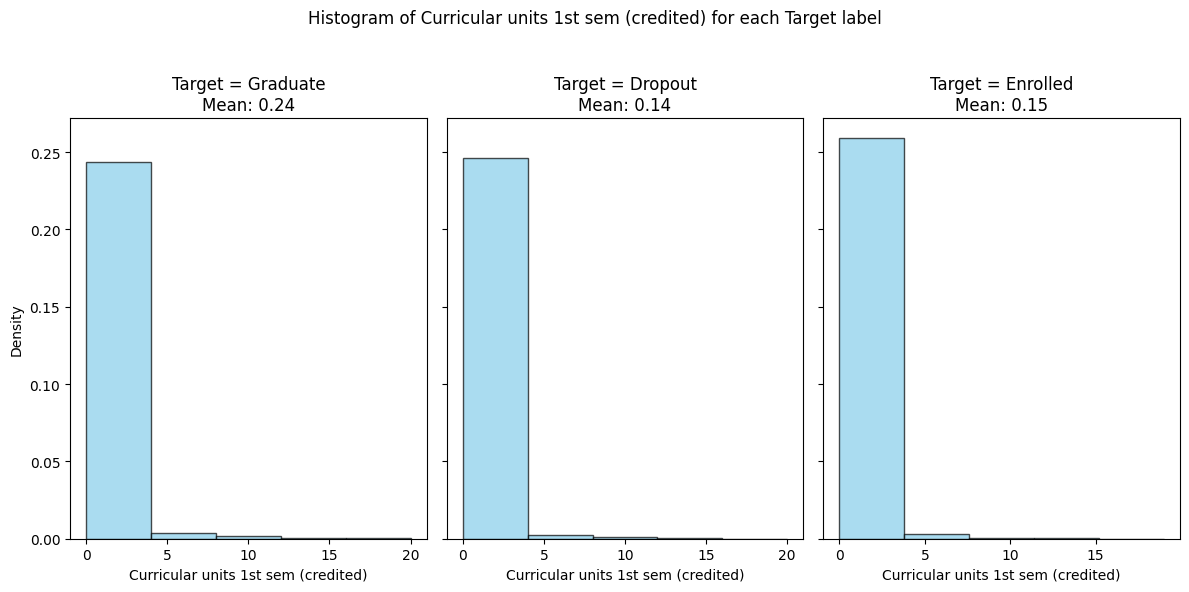

In [61]:
up.histogram_on_target(train, "Target", "Unemployment rate")
up.histogram_on_target(train, "Target", "International")
up.histogram_on_target(train, "Target", "Curricular units 1st sem (credited)")

# Preprocess before train

We keep the 14 most relevant features thanks to PCA results : [1, 2, 4, 5, 14, 17, 20, 22, 23, 24, 25, 26, 28, 29]

In [76]:
select_features = [train.columns[i] for i in [1, 2, 4, 5, 14, 17, 20, 22, 23, 24, 25, 26, 28, 29]]
print(select_features)

label_target = {'Graduate':0, 'Dropout': 1, 'Enrolled':2}
label_target_r = {0: 'Graduate', 1: 'Dropout', 2: 'Enrolled'}

Id = test['id']
Target = train['Target'].apply(lambda x: label_target[x])

sc = StandardScaler()

train_final = sc.fit_transform(train[select_features])
test_final = sc.transform(test[select_features])

['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 'Displaced', 'Tuition fees up to date', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)']


# Split

In [64]:
x_train, x_val, y_train, y_val = train_test_split(train_final,
                                                  Target,
                                                  test_size = 0.3, random_state = 42)
print("len x_train: ",x_train.shape)
print("len x_val: ", x_val.shape)
print("len label_train: ",y_train.shape)
print("len label_val: ", y_val.shape)

len x_train:  (53562, 14)
len x_val:  (22956, 14)
len label_train:  (53562,)
len label_val:  (22956,)


# First prediction

[INFO] : cross val score...
Cross-validation scores for each fold: [0.77354616 0.77298609 0.77865945 0.77315161 0.77660568]
Mean CV score: 0.7749897958877793
Standard deviation of CV scores: 0.0022607641048436344

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7848492768775048


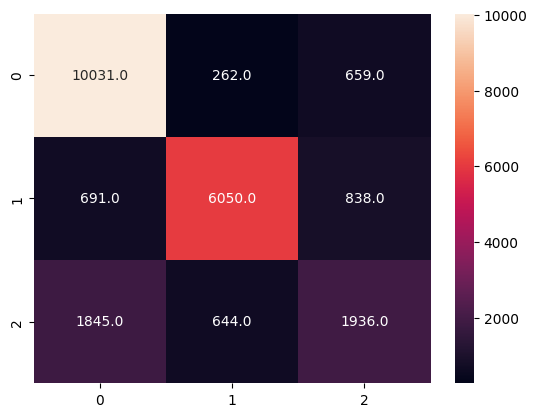

In [77]:
# preprocessing with StandardScaler and MinMaxScaler important

clf = LogisticRegression()

clf = utilities.train_model(clf, True, x_train, y_train, x_val, y_val)


[INFO] : cross val score...
Cross-validation scores for each fold: [0.78260058 0.78801456 0.7845407  0.78743465 0.7901419 ]
Mean CV score: 0.7865464784327767
Standard deviation of CV scores: 0.002663246885663452

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7941278968461405


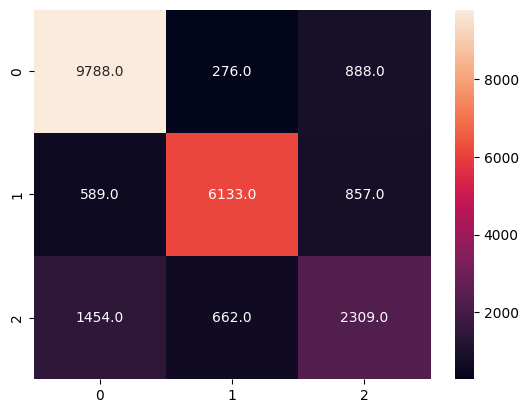

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [70]:
# preprocessing with StandardScaler and MinMaxScaler not important

XGB = XGBClassifier(eval_metric='mlogloss')

utilities.train_model(XGB, True, x_train, y_train, x_val, y_val)


[INFO] : cross val score...
Cross-validation scores for each fold: [0.77662653 0.77746663 0.78127334 0.77828603 0.78164675]
Mean CV score: 0.7790598563637444
Standard deviation of CV scores: 0.0020322295678192074

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7895974908520648


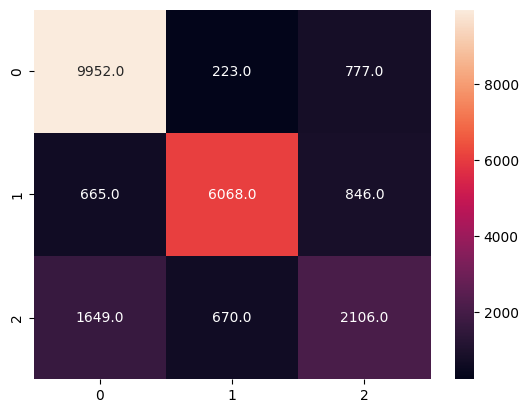

In [71]:
from catboost import CatBoostClassifier

#iterations=50, learning_rate=0.1, depth=3,random_seed=0, verbose=0
#iterations=285, learning_rate=0.11949697012050743, depth=3,random_seed=0, verbose=0

Cat = CatBoostClassifier(iterations=50, 
                         learning_rate=0.1, 
                         depth=3,random_seed=0, 
                         verbose=0)

utilities.train_model(Cat, True, x_train, y_train, x_val, y_val)

[INFO] : cross val score...
Cross-validation scores for each fold: [0.75450387 0.7669187  0.76054892 0.76652353 0.7599888 ]
Mean CV score: 0.7616967620879256
Standard deviation of CV scores: 0.004616028084742069

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7691671022826276


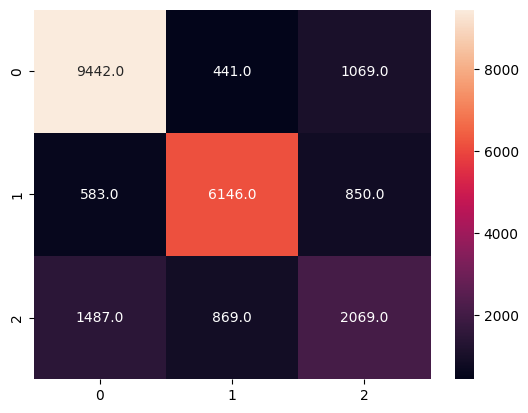

RandomForestClassifier()

In [72]:
from sklearn.ensemble import RandomForestClassifier

rfc= RandomForestClassifier(n_estimators = 100)

utilities.train_model(rfc, True, x_train, y_train, x_val, y_val)

[INFO] : cross val score...
Cross-validation scores for each fold: [0.78605433 0.78932139 0.78622106 0.78911501 0.79462285]
Mean CV score: 0.7890669272645304
Standard deviation of CV scores: 0.0031019378216734154

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7973078933612128


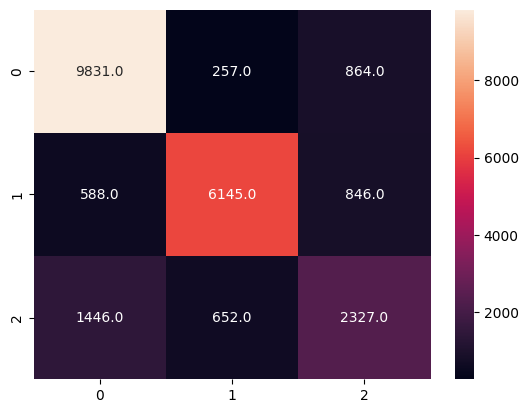

LGBMClassifier(verbose=-1)

In [75]:
lgbm= LGBMClassifier(verbose = -1)

utilities.train_model(lgbm, True, x_train, y_train, x_val, y_val)

In [78]:
def submission(model, test, Id, dict_target):
    pred = model.predict(test)

    submission = pd.DataFrame({'id': Id,
                               'Target': [dict_target[p] for p in pred]})

    # Save submission to a CSV file
    submission.to_csv('submission.csv', index=False)
    
submission(clf, test_final, Id, label_target_r)